In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import TranscriptionDataset, collate_fn
from Model.encoder_net import EncoderNet
from Model.decoder_net import DecoderNet
from train import train_transcriber
print(torch.__version__)
from tqdm import tqdm_notebook as tqdm

0.4.0


### 1. Make Sure that the Encoder/Decoder and Work

In [2]:
def train_localizer_network():
    IMAGE_DIR = '../Data/FullData/Cropped_Images/'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    WORD_VEC_PATH = '../Data/FullData/Transcriptions/nutrition_vectors.npy'
    INDEX_TO_TERM_PATH = '../Data/FullData/Transcriptions/index_term_dict.npy'
    TERM_TO_INDEX_PATH = '../Data/FullData/Transcriptions/term_index_dict.npy'
    PATH_TO_MEAN_IMAGE = '../Data/FullData/512_512_mean.npy'
    
    debug = not torch.cuda.is_available()
    train_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='train'
    )
    train_loader = DataLoader( 
        train_dataset, batch_size=116, shuffle=True,
        num_workers=16, collate_fn=collate_fn
    )
    config = {
        'keep_prob': 1
    }
    learning_rate = 5e-3
    dev_loader = DataLoader(
        TranscriptionDataset(
            IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
            PATH_TO_MEAN_IMAGE, debug=debug, split='dev',
        ),
        batch_size=116, shuffle=True, num_workers=16, collate_fn=collate_fn
    )
    encoder = EncoderNet(config_params=config)
    
    word_vectors = train_dataset.get_word_vectors()
    embed_size = len(word_vectors[0])
    output_size = train_dataset.get_output_size()
    decoder = DecoderNet(word_vectors, output_size, embed_size)
    
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(
        parameters, lr=learning_rate
    )
    results = train_transcriber(
        encoder, decoder, optimizer, train_loader, dev_loader,
        epochs=1
    )
    return results

In [3]:
train_losses, dev_losses, train_bleu, dev_bleu = train_localizer_network()

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

torch.Size([10, 100])
PackedSequence(data=tensor([[ 1.7721e-02,  4.9675e-02,  5.5011e-02,  ..., -2.3480e-03,
          1.9462e-02,  1.5801e-02],
        [ 1.9583e-02,  4.8497e-02,  5.5206e-02,  ..., -3.3501e-03,
          2.0140e-02,  1.6210e-02],
        [ 1.8863e-02,  4.9219e-02,  5.6185e-02,  ..., -1.5596e-03,
          1.9227e-02,  1.5341e-02],
        ...,
        [-2.7572e-02,  5.9783e-02,  1.1584e-01,  ..., -1.1464e-02,
          1.6604e-02,  7.5798e-02],
        [-2.9591e-02,  6.3544e-02,  1.2128e-01,  ..., -1.2610e-02,
          1.6083e-02,  8.2423e-02],
        [-2.6398e-02,  5.6642e-02,  1.1304e-01,  ..., -1.0780e-02,
          1.9372e-02,  7.0558e-02]]), batch_sizes=tensor([ 10,  10,  10,  10,  10,   9,   9,   9,   9,   9,   9,   9,
          8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
          8,   8,   8,   8,   8,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   6,   6,   6,   6,   6,   6,   6,   6,   6,
          6,   6,   6,   6,   6,   6,   6

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

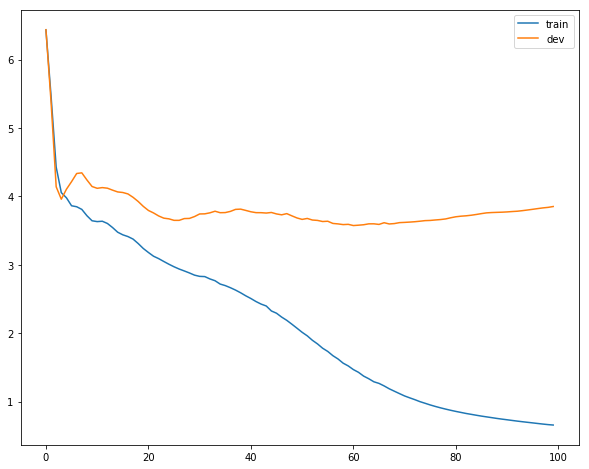

In [38]:
plt.plot(train_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()

In [6]:
def ensure_all_data_is_available():
    import numpy as np
    data_path = '../Data/FullData/train_dev_test.npy'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    annotations = np.load(ANNOTATION_PATH).item()
    images = (
            np.load(data_path).item()['train'] + np.load(data_path).item()['dev'] + 
            np.load(data_path).item()['test']
    )
    bad = []
    for img in tqdm(images):
        num = img[:img.rfind('_')]
        nut = '1_' + num; ingr = '0_'+num
        if nut not in annotations or ingr not in annotations:
            bad.append(num)
    print(set(bad))

In [8]:
# ensure_all_data_is_available()